### Imports

In [1]:
import boto3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import transforms as T
from torchvision.models import resnet34, ResNet34_Weights
import pandas as pd
from torchvision.io import read_image
import matplotlib.pyplot as plt
import time
import os
from dotenv import dotenv_values
from PIL import Image
from torch.utils.data import Dataset, DataLoader, sampler
from env_enum import TargetEnvKeys

### Global vars

In [2]:
random_seed = 42
dtype = torch.float32
env_path = "../.env"

### Random Seed Setup

In [3]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

### Device Setup

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use: {device}")

Device in use: cuda


### Dataset class definition

In [5]:
class PlaneDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.to_pil = T.ToPILImage()

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = self.to_pil(image).convert("RGB")
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label


### Data reference

In [6]:
env_config = dotenv_values(env_path)

data_key = TargetEnvKeys.DATA_TARGET_DIR.value
train_img_dir = env_config[data_key]

label_key = TargetEnvKeys.LABEL_TARGET_DIR.value
labels_csv_path = env_config[label_key]

### Dataset setup

In [7]:
preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = PlaneDataset(labels_csv_path, train_img_dir, preprocess)

### Train and Validation sizes configuration

In [8]:
dataset_size = len(train_dataset)
val_size = int(dataset_size * 0.1)
train_size = dataset_size - val_size

### Hyperparameters definiton

In [9]:
batch_size = 32
learning_rate = 1e-3
momentum = 9e-1
num_epochs = 3

### Data loaders setup

In [10]:
generator = torch.Generator().manual_seed(random_seed)

train_sampler = sampler.SubsetRandomSampler(range(train_size), generator=generator)
val_sampler = sampler.SubsetRandomSampler(range(train_size, dataset_size), generator=generator)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

data_loaders = {"train":train_dataloader, "val":val_dataloader}
data_sizes = {"train":train_size, "val":val_size}

### Dataset sample examples

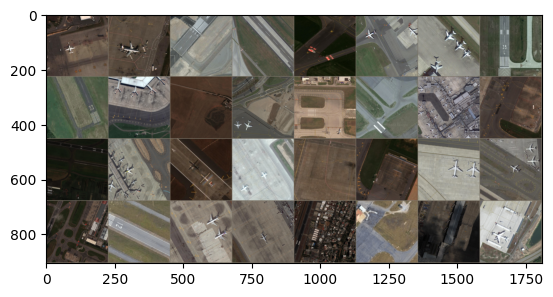

In [11]:
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(data_loaders["train"]))

out = torchvision.utils.make_grid(inputs)

imshow(out)

### Model definition

In [12]:
model = resnet34(weights=ResNet34_Weights.DEFAULT)

num_classes = 2
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

model = model.to(device=device)

### Loss and optimizer setup

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

### Train method definition

In [14]:
def train(num_epochs, model, train_dataloader, val_dataloader, optimizer, criterion):
    metrics = {"train": {"loss":list(), "accuracy": list()}, "val": {"loss":list(), "accuracy":list()}}
    
    for epoch in range(num_epochs):
        print(f"\nEpoch: {epoch + 1}/{num_epochs}")
        print("-" * 40)
        
        for mode in ["train", "val"]:
                
            if mode == "train":
                model.train()
            else:
                model.eval()
                
            running_accuracy = 0
            loss_history = []
            
            for inputs, labels in data_loaders[mode]:
                inputs = inputs.to(device=device, dtype=dtype)
                labels = labels.to(device=device, dtype=torch.long)

                with torch.set_grad_enabled(mode == "train"):
                    optimizer.zero_grad()
                    output = model(inputs)
                    pred_labels = torch.argmax(output, axis=1)
                    loss = criterion(output, labels)

                    if mode == "train":
                        loss.backward()
                        optimizer.step()
                    
                    running_accuracy += (pred_labels == labels).sum()
                    loss_history.append(loss.item())
                    
            epoch_accuracy = running_accuracy / data_sizes[mode]
            epoch_loss = torch.tensor([loss_history]).mean()
            
            metrics[mode]["loss"].append(epoch_loss)
            metrics[mode]["accuracy"].append(epoch_accuracy)
            
            print(f"{mode} Accuracy: {epoch_accuracy:.4f}%, Loss: {epoch_loss:.4f}")
        
    return metrics

In [15]:
metrics = train(num_epochs, model, train_dataloader, val_dataloader, optimizer, criterion)


Epoch: 1/3
----------------------------------------
train Accuracy: 0.7313%, Loss: 0.5295
val Accuracy: 0.6216%, Loss: 0.7298

Epoch: 2/3
----------------------------------------
train Accuracy: 0.8945%, Loss: 0.2556
val Accuracy: 0.6959%, Loss: 0.5756

Epoch: 3/3
----------------------------------------
train Accuracy: 0.9304%, Loss: 0.1594
val Accuracy: 0.7703%, Loss: 0.5234


### Metrics Plots

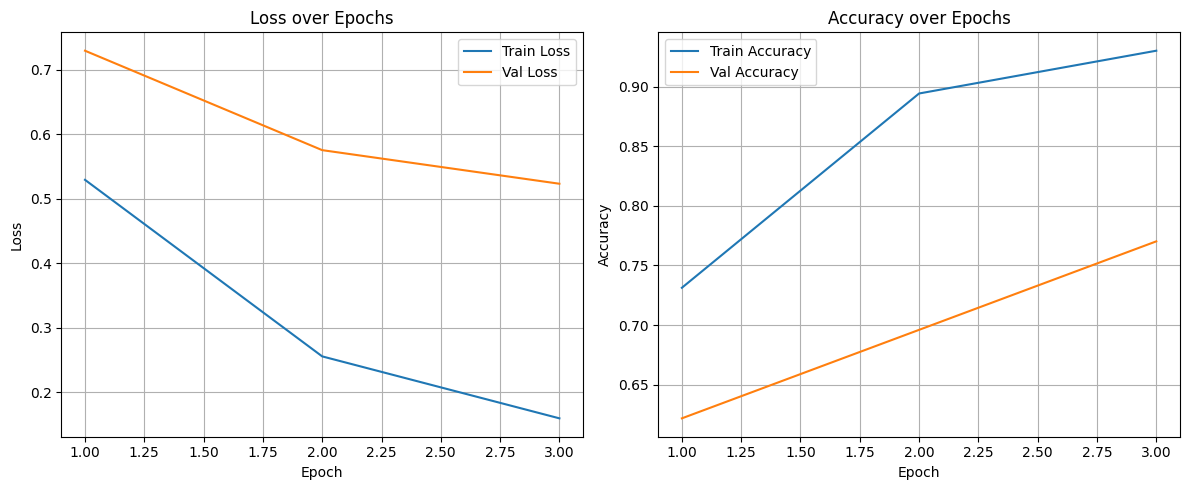

In [18]:
epochs = range(1, 4)
train_loss = metrics["train"]["loss"]
val_loss = metrics["val"]["loss"]
train_acc = metrics["train"]["accuracy"]
val_acc = metrics["val"]["accuracy"]

train_loss = [loss.cpu() for loss in train_loss]
val_loss = [loss.cpu() for loss in val_loss]

train_acc = [acc.cpu() for acc in train_acc]
val_acc = [acc.cpu() for acc in val_acc]


# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
